# Preprocessing

Import required libraries.

In [1]:
import time
import scipy.io
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import antropy as ant
import EntropyHub as EH
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score



### Load data
Load raw EEG data for normal and fatigue states of all twelve people from .cnt files. Save loaded data of normal state to ```raw_normal_list``` array and fatigue to ```raw_fatigue_list``` array.

In [22]:
raw_normal_list = list()
raw_fatigue_list = list()

num_of_people = 12

for i in range(1, num_of_people + 1):
    file_name_normal = f"data/{i}/Normal state.cnt"
    file_name_fatigue = f"data/{i}/Fatigue state.cnt"

    raw_normal = mne.io.read_raw_cnt(file_name_normal, preload=True, verbose=False).load_data()
    raw_fatigue = mne.io.read_raw_cnt(file_name_fatigue, preload=True, verbose=False).load_data()
    
    raw_normal_list.append(raw_normal)
    raw_fatigue_list.append(raw_fatigue)

# verify results
assert(len(raw_normal_list) == num_of_people)
assert(len(raw_fatigue_list) == num_of_people)

<ipython-input-22-5241e8e8a390>:10: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw_normal = mne.io.read_raw_cnt(file_name_normal, preload=True, verbose=False).load_data()
<ipython-input-22-5241e8e8a390>:10: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw_normal = mne.io.read_raw_cnt(file_name_normal, preload=True, verbose=False).load_data()
<ipython-input-22-5241e8e8a390>:11: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw_fatigue = mne.io.read_raw_cnt(file_name_fatigue, preload=True, verbose=False).load_data()
/home/satan/.local/lib/python3.9/site-packages/mne/io/cnt/cnt.py:241: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
<ipython-input-22-5241e8e8a390>:11: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw_fatigue = mne.io.read_raw_cnt(file_name_fatigue, preload=True,

### Display data

Display short info about the data. Use the first item from the array.

In [23]:
raw_normal_list[0].info

<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

In [24]:
raw_fatigue_list[0].info

<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

Display PSD chart. A Power Spectral Density (PSD) is the measure of signal's power content versus frequency. Unprocessed data at the beginning is very noisy and unreadable.

<ipython-input-25-dad6756d165a>:1: UserWarning: Infinite value in PSD for channels HEOR, FP2, F3, FT8, C3, C4, TP7, TP8, PZ, PO2.
These channels might be dead.
  raw_normal_list[0].plot_psd()


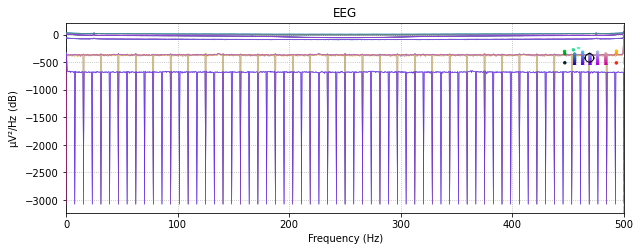

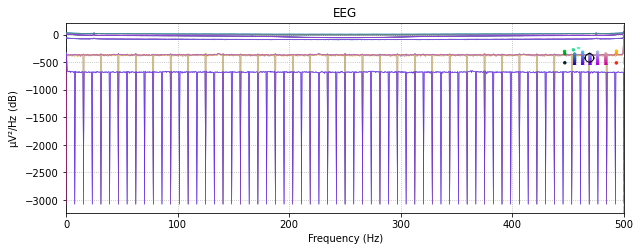

In [25]:
raw_normal_list[0].plot_psd()

<ipython-input-26-252757f94928>:1: UserWarning: Infinite value in PSD for channels FP2, VEOL, F3, F4, FT7, C3, C4, CPZ, T5, PZ, T6, PO2.
These channels might be dead.
  raw_fatigue_list[0].plot_psd()


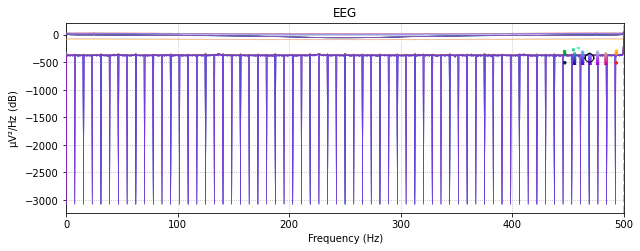

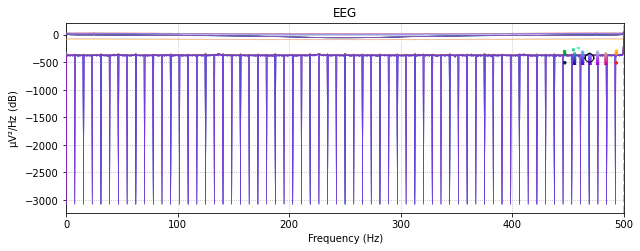

In [26]:
raw_fatigue_list[0].plot_psd()

### Crop signal

The original signal duration is ten minutes. Cut out the first five mintues as paper states only the last five minutes is used.

Repeat the process for all signals in the array, both for normal and fatigue state.

NOTE:
There is a noise at the end, so dataset could be improved by not taking the last 30 seconds into account. Instead, shift everything  30 seconds to the left. E.g: tmin=270, tmax=570

In [27]:
for i in range(num_of_people):
    raw_normal = raw_normal_list[i]
    raw_normal.crop(tmin=300, tmax=600)

    raw_fatigue = raw_fatigue_list[i]
    raw_fatigue.crop(tmin=300, tmax=600)

### Clean channels
Extract thirty channels mentioned in the paper, remove all other channels from the dataset.

After this step, only thirty EEG channels should remain.

Repeat the process for all signals in the array, both for normal and fatigue state.

In [28]:
goods_ch = set(['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FT7', 'FC3', 'FCZ', 'FC4', 'FT8', 'T3', 'C3', 'CZ', 'C4', 'T4', 'TP7', 'CP3', 'CPZ', 'CP4', 'TP8', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'OZ', 'O2'])

for i in range(num_of_people):
    raw_normal = raw_normal_list[i]
    raw_fatigue = raw_fatigue_list[i]

    all_ch_normal = set(raw_normal.info["ch_names"])
    bads_ch_normal = list(all_ch_normal - goods_ch)

    all_ch_fatigue = set(raw_fatigue.info["ch_names"])
    bads_ch_fatigue = list(all_ch_fatigue - goods_ch)

    raw_normal.info["bads"].extend(bads_ch_normal)
    raw_normal.pick_channels(goods_ch)

    raw_fatigue.info["bads"].extend(bads_ch_fatigue)
    raw_fatigue.pick_channels(goods_ch)

### Filter

#### Notch filter
Apply notch filter to remove power-line noise. Power-line noise is a noise created by the electrical network and it is composed of sharp peaks at 50Hz. Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz ...

Exclude bad channels and apply the filter only on good channels.

Repeat the process for all signals in the array, both for normal and fatigue state.

In [29]:
for i in range(num_of_people):
    raw_normal = raw_normal_list[i]
    raw_fatigue = raw_fatigue_list[i]

    picks_normal = mne.pick_types(raw_normal.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    raw_normal.notch_filter(np.arange(50, 251, 50), picks=picks_normal)
    
    picks_fatigue = mne.pick_types(raw_fatigue.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    raw_fatigue.notch_filter(np.arange(50, 251, 50), picks=picks_fatigue)

Display PSD chart after applying the notch filter.

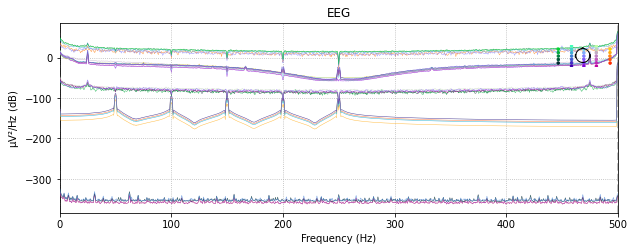

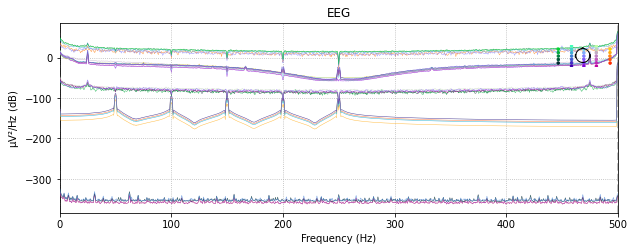

In [30]:
raw_normal_list[0].plot_psd()

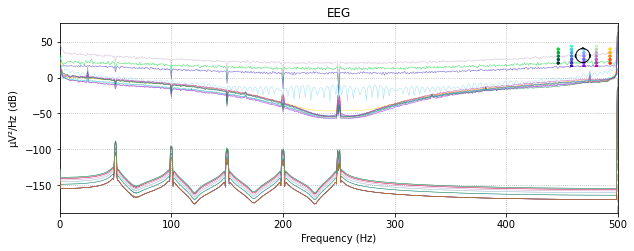

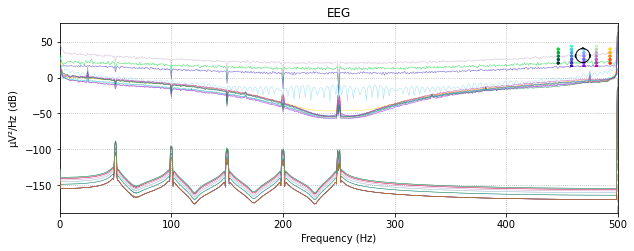

In [31]:
raw_fatigue_list[0].plot_psd()

#### Band pass filter

Apply band pass filter to remove additional noise.

In [32]:
for i in range(num_of_people):
    raw_normal = raw_normal_list[i]
    raw_fatigue = raw_fatigue_list[i]

    raw_normal.filter(0.15, 40)
    raw_fatigue.filter(0.15, 40)

Display PSD chart after applying the band pass filter.

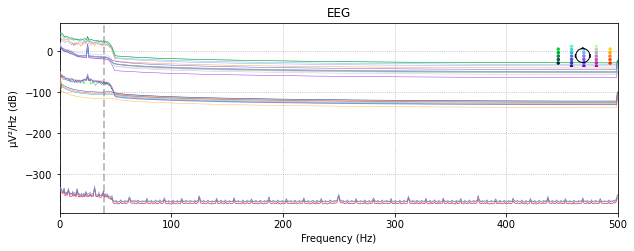

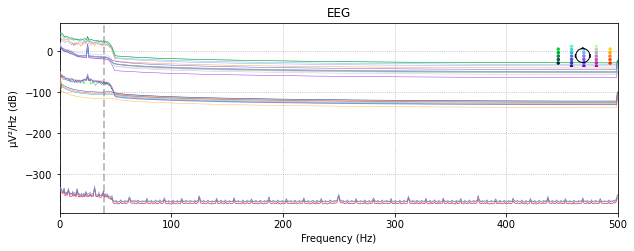

In [33]:
raw_normal_list[0].plot_psd()

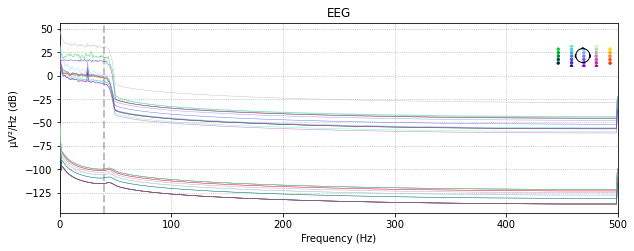

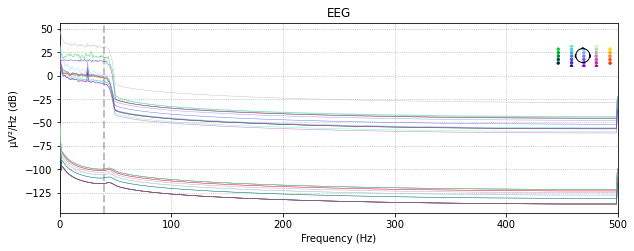

In [34]:
raw_fatigue_list[0].plot_psd()

Display the raw data plot after preprocessing.

/home/satan/.local/lib/python3.9/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


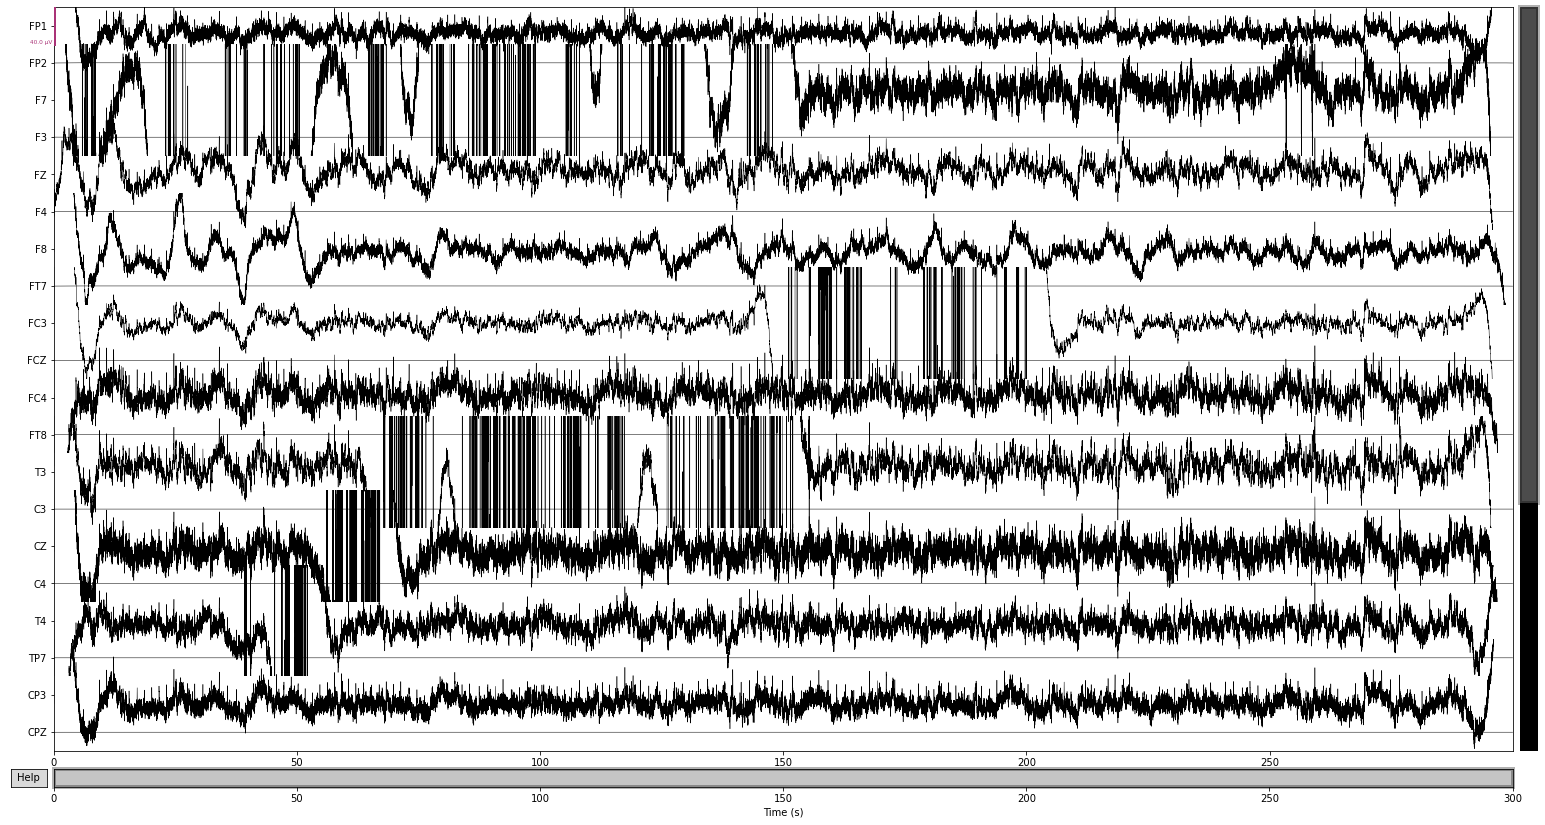

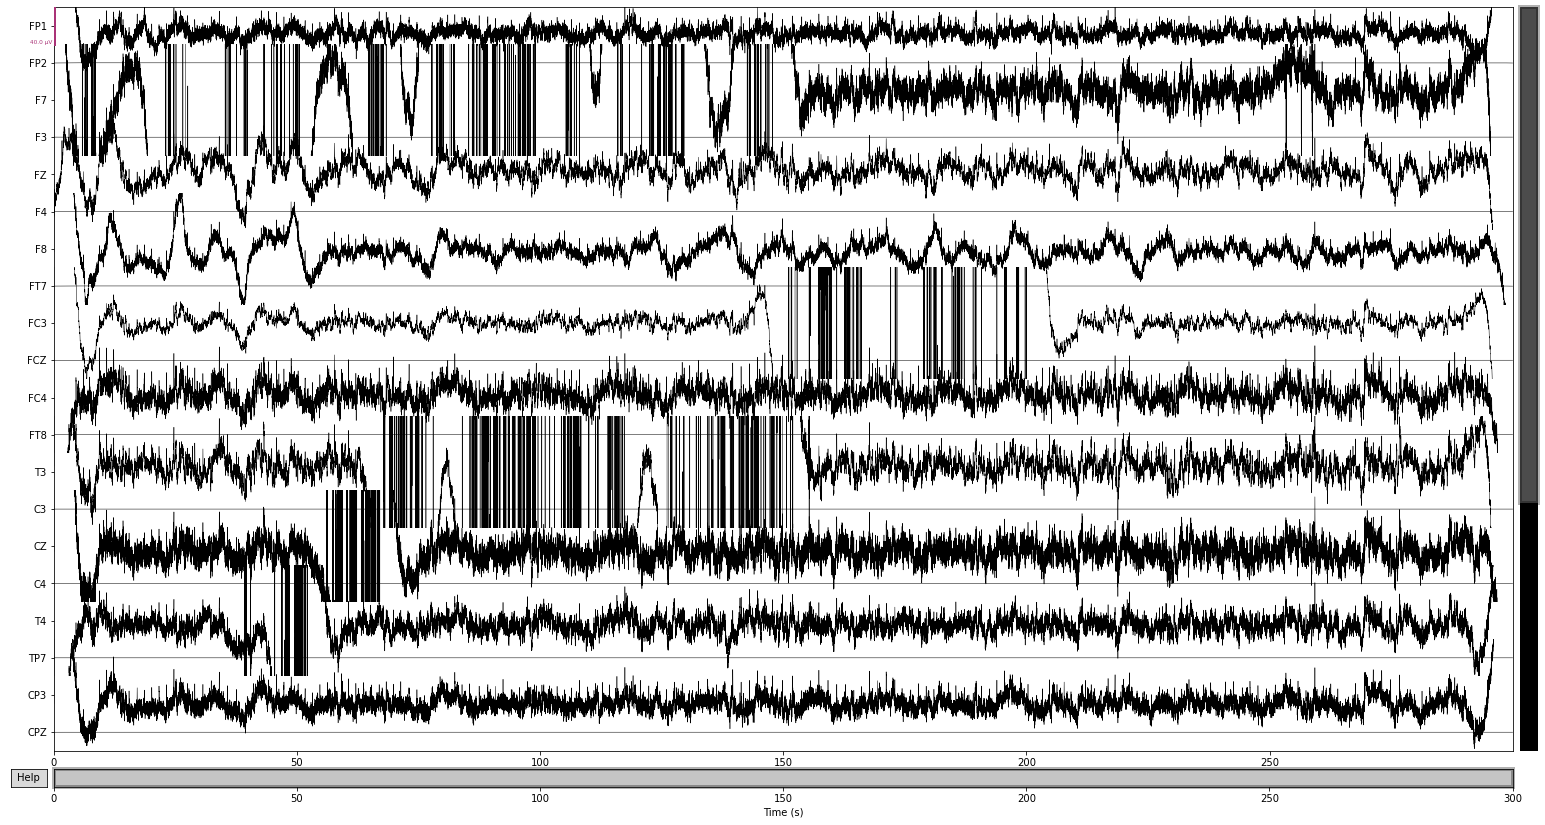

In [35]:
raw_normal_list[0].plot(start=0, duration=300, show=True)

/home/satan/.local/lib/python3.9/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


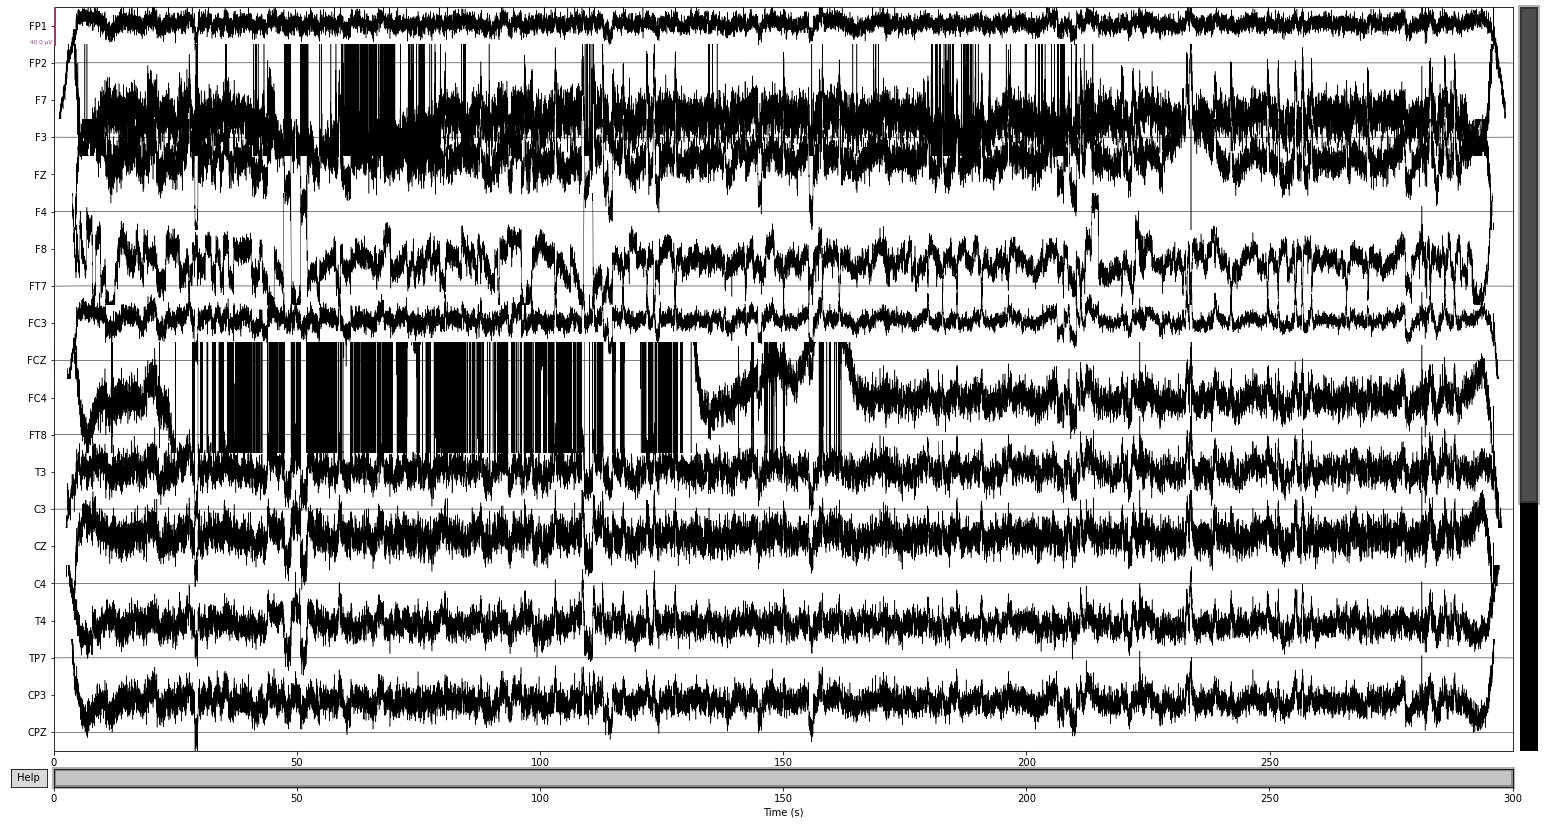

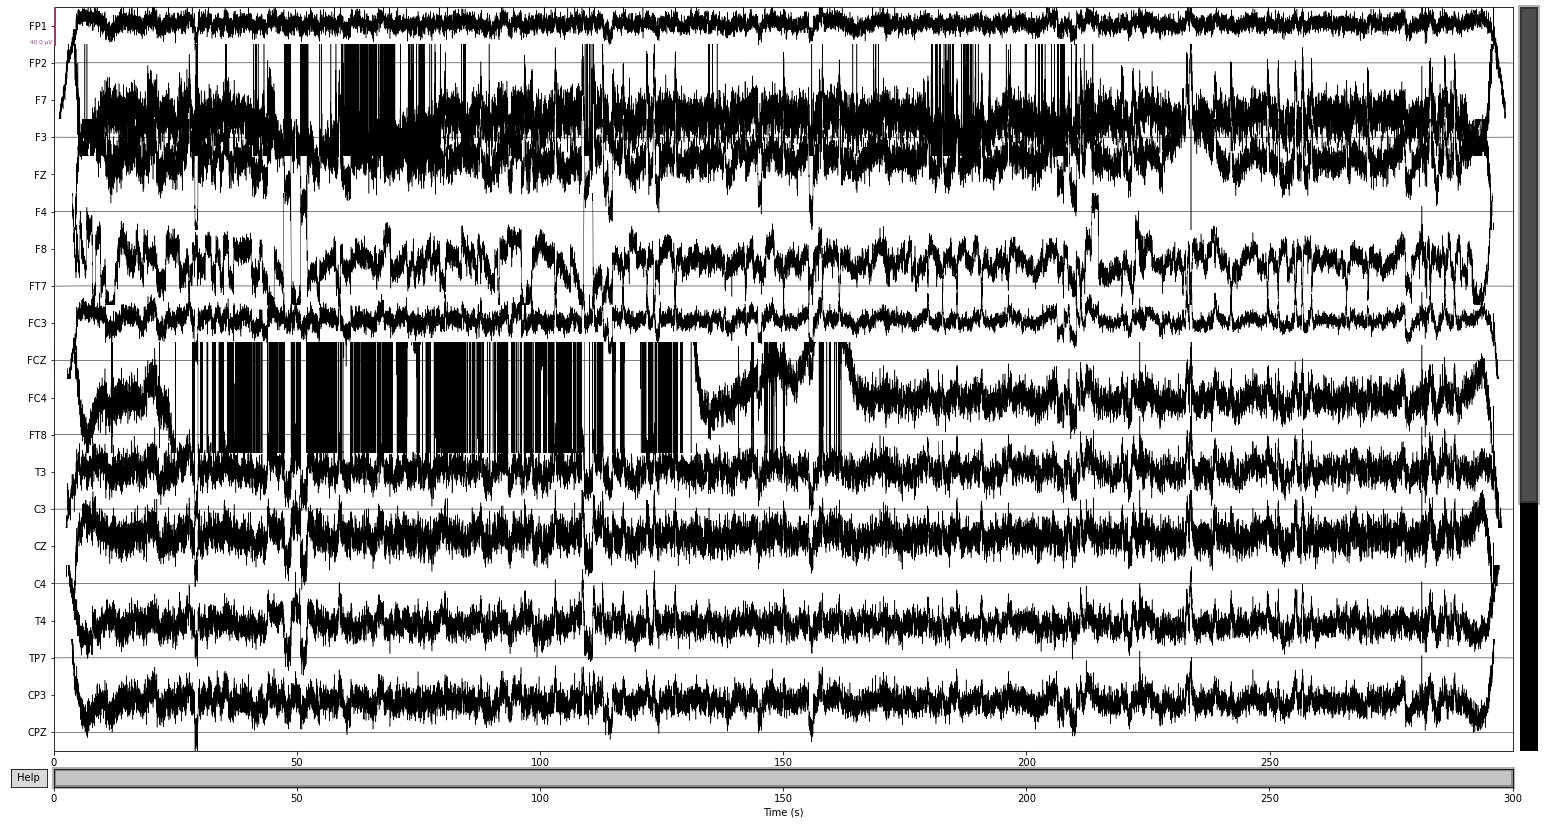

In [36]:
raw_fatigue_list[0].plot(start=0, duration=300, show=True)

### Create epochs

Section data into 1 second epochs to produce 300 epochs for each channel (30 channels) in total.

After this step every epoch should consist of 1000 values. Entropies will be calculated from these 1000 values.

Repeat the process for all signals in the array, both for normal and fatigue state.

In [48]:
epoch_duration = 1

structured_data_normal_list = list()
structured_data_fatigue_list = list()

for i in range(num_of_people):
    raw_normal = raw_normal_list[i]
    raw_fatigue = raw_fatigue_list[i]

    epochs_normal = mne.make_fixed_length_epochs(raw_normal, duration=epoch_duration, preload=False, verbose=False)
    epochs_fatigue = mne.make_fixed_length_epochs(raw_fatigue, duration=epoch_duration, preload=False, verbose=False)

    structured_data_normal = epochs_normal.get_data()
    structured_data_fatigue = epochs_fatigue.get_data()
    
    structured_data_normal_list.append(structured_data_normal)
    structured_data_fatigue_list.append(structured_data_fatigue)


# verify results
num_epochs = 300
num_channels = 30
num_data_in_epoch = 1000

assert(len(structured_data_normal_list) == num_of_people)
assert(len(structured_data_fatigue_list) == num_of_people)

for i in range(num_of_people):
    assert(structured_data_normal_list[i].shape[0] == num_epochs)
    assert(structured_data_normal_list[i].shape[1] == num_channels)
    assert(structured_data_normal_list[i].shape[2] == num_data_in_epoch)

    assert(structured_data_fatigue_list[i].shape[0] == num_epochs)
    assert(structured_data_fatigue_list[i].shape[1] == num_channels)
    assert(structured_data_fatigue_list[i].shape[2] == num_data_in_epoch)

# Feature extraction

### Calculate entropy

Calculate AE, PE, SE and FE entropy for each epoch for every channel. Store results in separate matrices both for normal and fatigue state.

In [54]:
AE_normal_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))
PE_normal_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))
SE_normal_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))
FE_normal_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))

AE_fatigue_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))
PE_fatigue_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))
SE_fatigue_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))
FE_fatigue_matrix = np.zeros(shape=(num_of_people, num_epochs, num_channels, 1))

In [61]:
for person_num in range(num_of_people):
    for epoch_num in range(num_epochs):
        for channel_num in range(num_channels):

            # extract data array for each state
            data_normal = structured_data_normal_list[person_num][epoch_num][channel_num]
            data_fatigue = structured_data_fatigue_list[person_num][epoch_num][channel_num]

            # calculate entropies for normal state
            AE_normal = ant.app_entropy(data_normal)
            PE_normal = ant.spectral_entropy(data_normal, sf=1000)
            SE_normal = ant.sample_entropy(data_normal)
            r_normal = np.std(data_normal, ddof=1) * 0.2
            FE_normal = (EH.FuzzEn(data_normal, m=2, r=(r_normal,1)))[0][-1]

            # fill matrix with entropies for normal state
            AE_normal_matrix[person_num][epoch_num][channel_num] = AE_normal
            PE_normal_matrix[person_num][epoch_num][channel_num] = PE_normal
            SE_normal_matrix[person_num][epoch_num][channel_num] = SE_normal
            FE_normal_matrix[person_num][epoch_num][channel_num] = FE_normal

            # calculate entropies for fatigue state
            AE_fatigue = ant.app_entropy(data_fatigue)
            PE_fatigue = ant.spectral_entropy(data_fatigue, sf=1000)
            SE_fatigue = ant.sample_entropy(data_fatigue)
            r_fatigue = np.std(data_fatigue, ddof=1) * 0.2
            FE_fatigue = (EH.FuzzEn(data_fatigue, m=2, r=(r_fatigue,1)))[0][-1]

            # fill matrix with entropies for fatigue state
            AE_fatigue_matrix[person_num][epoch_num][channel_num] = AE_fatigue
            PE_fatigue_matrix[person_num][epoch_num][channel_num] = PE_fatigue
            SE_fatigue_matrix[person_num][epoch_num][channel_num] = SE_fatigue
            FE_fatigue_matrix[person_num][epoch_num][channel_num] = FE_fatigue

3.961398140891622
[-6.77626358e-20  1.23744879e-04  2.44212095e-04  3.58280829e-04
  4.63137812e-04  5.56408057e-04  6.36261771e-04  7.01484596e-04
  7.51522602e-04  7.86484617e-04  8.07109952e-04  8.14701872e-04
  8.11031739e-04  7.98225264e-04  7.78627674e-04  7.54666520e-04
  7.28715623e-04  7.02973729e-04  6.79350603e-04  6.59385834e-04
  6.44186462e-04  6.34404692e-04  6.30234615e-04  6.31443983e-04
  6.37426950e-04  6.47283364e-04  6.59900828e-04  6.74055084e-04
  6.88500933e-04  7.02071610e-04  7.13749904e-04  7.22736606e-04
  7.28487208e-04  7.30742556e-04  7.29519425e-04  7.25098724e-04
  7.17980671e-04  7.08843080e-04  6.98471136e-04  6.87699076e-04
  6.77337934e-04  6.68126598e-04  6.60671754e-04  6.55417582e-04
  6.52616509e-04  6.52328646e-04  6.54422567e-04  6.58598894e-04
  6.64420952e-04  6.71359175e-04  6.78834218e-04  6.86263421e-04
  6.93103994e-04  6.98894284e-04  7.03279953e-04  7.06036739e-04
  7.07076316e-04  7.06451038e-04  7.04333781e-04  7.01002310e-04
  6.968

In [ ]:
np.save("data/AE_normal_matrix", AE_normal_matrix)
np.save("data/PE_normal_matrix", PE_normal_matrix)
np.save("data/SE_normal_matrix", SE_normal_matrix)
np.save("data/FE_normal_matrix", FE_normal_matrix)

np.save("data/AE_fatigue_matrix", AE_fatigue_matrix)
np.save("data/PE_fatigue_matrix", PE_fatigue_matrix)
np.save("data/SE_fatigue_matrix", SE_fatigue_matrix)
np.save("data/FE_fatigue_matrix", FE_fatigue_matrix)